In [2]:
import astropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from astropy.coordinates.angle_utilities import hms_to_degrees, dms_to_degrees
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import re
import json
from collections import Counter
from operator import itemgetter
import scipy
from scipy.signal import argrelextrema

In [20]:
#ОКПЗ
data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|')

In [21]:
data = data[['J2000.0', 'Type']]

In [22]:
data = data.to_pandas()

In [23]:
data.Type = data.Type.map(lambda item: re.sub(':', '', str(item) ) if str(item).endswith(':') else str(item) )

In [24]:
data.rename(columns={'J2000.0':'coord'}, inplace=True)

In [25]:
data.drop(index=data[data.coord.map(lambda x: type(x) is not str )].index.values.tolist(), inplace=True)

In [26]:
data = data[ data.coord.map(lambda x: len(str(x)) == 19 ) ]

In [27]:
data['ra'] = data.coord.map(lambda x: x[:9])
data['dec'] = data.coord.map(lambda x: x[9:])

In [28]:
data.dec = data.dec.map(lambda x: x.replace(' ', '') )

In [29]:
data = data[ (data.dec.map(lambda x: x.startswith('+')) | data.dec.map(lambda x: x.startswith('-')) )
            & data.dec.map(lambda x: len(x) == 9 ) ]

In [30]:
data.reset_index(drop=True, inplace=True)

In [31]:
data.ra = data.ra.map(lambda x: hms_to_degrees(float(x[:2]), float(x[2:4]), float(x[4:])) )
data.dec = data.dec.map(lambda x: dms_to_degrees(float(x[:3]), float(x[3:5]), float(x[5:])))

In [ ]:
#sorted(Counter(data.Type).items(), key=itemgetter(1), reverse=True)

In [19]:
################################################################

        Use astropy.stats.LombScargle instead. [warnings]


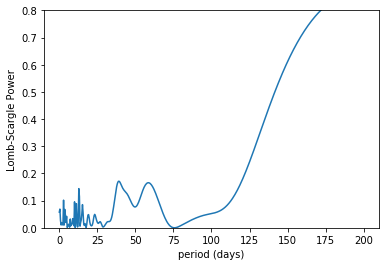

In [376]:
from astroML.time_series import lomb_scargle
periods = np.linspace(0.01, 200, 500)
ang_freqs = 2 * np.pi / periods
power = lomb_scargle(np.array(obj_mjd), np.array(obj_mag), np.array(obj_magerr), ang_freqs)

# plot the results
fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(ylim=(0, 0.8), xlabel='period (days)',
       ylabel='Lomb-Scargle Power');

In [377]:
peak_data = scipy.signal.find_peaks(power,prominence=0.05)

f1=np.max(power[peak_data[0]])
ind1=power[peak_data[0]].argmax()
power[peak_data[0][ind1]]=0
f2=np.max(power[peak_data[0]])
ind2=power[peak_data[0]].argmax()
print(periods[peak_data[0][ind1]])
print(periods[peak_data[0][ind2]])
# print(periods[ind1])
# print(periods[ind2])

39.28659318637274
58.524108216432865


In [374]:
print(periods[peak_data[0]])
print(power[peak_data[0]])

[ 2.81547094  3.61703407 10.02953908 11.23188377 12.83501002 15.2396994
 39.28659319 58.52410822]
[0.10172417 0.0677086  0.09548401 0.08883154 0.14417291 0.08527505
 0.         0.16583848]


In [320]:
model = LombScargleFast().fit(np.array(obj_mjd), np.array(obj_mag), np.array(obj_magerr))

period, power = model.periodogram_auto(nyquist_factor=200)

print("period range: ({0}, {1})".format(period.min(), period.max()))
print("number of periods: {0}".format(len(period)))
print(type(periods))

period range: (0.04277258831521739, 983.76953125)
number of periods: 23000
<class 'numpy.ndarray'>


C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


In [327]:
power.argmax()

4

In [414]:
data1=data.iloc[0:3000]

In [415]:
%%time
from astroML.time_series import lomb_scargle
from gatspy.periodic import LombScargleFast
periods = np.linspace(0.01, 200, 500)
ang_freqs = 2 * np.pi / periods
my_data = pd.DataFrame({'obj_id':[],
                        'filter':[],
                        'mean_magn':[],
                        'amplitude':[],
                        'trand_angle':[],
                        'skew' : [],
                        'std' : [],
                        'max_PSD' : [],
                        'max_fs' : [],
                        'class':[]})

for item in data1.iterrows():
    try:
        resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=item[1].ra, 
                                                                                                                          dec=item[1].dec, 
                                                                                                                          r=5))
        res = resp.json()
        for obj_id in res.keys():
            if (res[obj_id]['meta']['filter']=='zg') & (len(res[obj_id]['lc'])>=20):
                obj_mjd = []
                obj_mag = []
                obj_magerr = []
                object_return = {}
                obj_filter = res[obj_id]['meta']['filter']
                
                for ii in res[obj_id]['lc']:
                    obj_mjd.append(ii['mjd'])
                    obj_mag.append(ii['mag'])
                    obj_magerr.append(ii['magerr'])
                
#                 Fs = 1/((np.array(obj_mjd).max() - np.array(obj_mjd).min() )/np.array(obj_mjd).size)
#                 Fs = np.linspace(0.01, 10)
                model = LombScargleFast().fit(obj_mjd, obj_mag, obj_magerr)
                period, power = model.periodogram_auto(nyquist_factor=200)
               
                object_return['obj_id'] = obj_id
                object_return['filter'] = res[obj_id]['meta']['filter']
                object_return['mean_magn'] = np.array(obj_mag).mean()
                object_return['amplitude'] = np.array(obj_mag).max() - np.array(obj_mag).min()
                object_return['trand_angle'] = np.polyfit(np.array(obj_mjd), np.array(obj_mag), 1)[0] 
                object_return['skew'] = scipy.stats.skew(np.array(obj_mag))
                
#                 D1=np.max(power[peak_data[0]])
#                 ind1=power[peak_data[0]].argmax()
#                 power[peak_data[0][ind1]]=0
#                 D2=np.max(power[peak_data[0]])
#                 ind2=power[peak_data[0]].argmax() 
                
                object_return['max_fs'] = 2*np.pi/(period[power.argmax()])
#                 object_return['max_fs1'] = 2*np.pi/(period[peak_data[0][ind2]])                
                object_return['max_PSD'] = np.max(power)
#                 object_return['max_PSD1'] = D2
                object_return['std'] = np.array(obj_mag).std()
                my_data = my_data.append( pd.DataFrame({'obj_id' : [ object_return['obj_id'] ],
                                                      'filter' : [ object_return['filter'] ],
                                                      'mean_magn' :[ object_return['mean_magn'] ],
                                                      'amplitude' : [ object_return['amplitude'] ], 
                                                      'trand_angle' : [ object_return['trand_angle'] ],
                                                      'skew' : [ object_return['skew'] ],
                                                      'std' : [ object_return['std'] ],
                                                      'max_PSD' : [ object_return['max_PSD']],
                                                      'max_fs' : [ object_return['max_fs'] ],
                                                      'class' : [ item[1].Type ] }),
                                         ignore_index = True)
            
    except Exception as ex:
        print("file {} has error".format(item[0]), ex)
    
    if item[0] % 1000 == 0 :
        my_data.to_csv('backup_' + str(item[0]) + '.csv')


C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

file 2720 has error Extra data: line 1 column 5 (char 4)


C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.war

Wall time: 6min 24s


C:\Users\rtut6\Anaconda3\lib\site-packages\gatspy\periodic\lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "


In [86]:
print(np.max(power))
period[power.argmax()]
# f[power.argmax()]

0.8454153026628567


0.17172603283898305

In [433]:
my_data.head(50)

,obj_id,filter,mean_magn,amplitude,trand_angle,skew,std,max_PSD,max_fs,class
0,695111400064435,zg,15.773690,1.453001,0.001723,1.398299,0.289004,0.440568,25.235225,SNI
1,696111300007125,zg,14.364000,2.814000,0.010997,-0.184409,0.831350,0.985015,0.024795,M
2,650116300021136,zg,13.844756,4.562000,0.014918,-0.331234,1.557293,0.983705,0.032783,M
3,739102400006782,zg,13.976114,3.712000,0.021147,-0.069805,1.090874,0.984434,0.019076,M
4,650112100009135,zg,15.054762,5.769000,-0.021382,-1.735134,1.443471,0.989442,0.015254,M
5,649105100012433,zg,15.799818,3.233000,0.010881,-0.149403,0.888956,0.971857,0.024806,M
6,650108200003776,zg,15.982404,3.213000,0.010525,-0.621399,0.873338,0.982417,0.018687,M
7,734105200007800,zg,15.820267,4.084000,-0.009956,-2.687832,0.939644,0.926416,0.005355,M
8,738106300003071,zg,13.382585,3.673000,-0.005394,-1.521083,0.857960,0.980416,0.018698,M
9,696111200004986,zg,14.843128,5.009001,-0.024167,-1.328166,1.183920,0.982609,0.018698,M


In [416]:
df = my_data.copy()

In [417]:
# оставляем только популярные классы

In [418]:
largest_classes = list(df['class'].value_counts().nlargest(n=8).index)

In [419]:
largest_classes

['M', 'RRAB', 'EA', 'LB', 'EW', 'SRB', 'SR', 'RRC']

In [420]:
to_replace = list(set(df['class'].values) - set(largest_classes))

In [421]:
df['class'].replace(list(to_replace), 'OTHER', inplace=True)

In [422]:
df

,obj_id,filter,mean_magn,amplitude,trand_angle,skew,std,max_PSD,max_fs,class
0,695111400064435,zg,15.773690,1.453001,0.001723,1.398299,0.289004,0.440568,25.235225,OTHER
1,696111300007125,zg,14.364000,2.814000,0.010997,-0.184409,0.831350,0.985015,0.024795,M
2,650116300021136,zg,13.844756,4.562000,0.014918,-0.331234,1.557293,0.983705,0.032783,M
3,739102400006782,zg,13.976114,3.712000,0.021147,-0.069805,1.090874,0.984434,0.019076,M
4,650112100009135,zg,15.054762,5.769000,-0.021382,-1.735134,1.443471,0.989442,0.015254,M
5,649105100012433,zg,15.799818,3.233000,0.010881,-0.149403,0.888956,0.971857,0.024806,M
6,650108200003776,zg,15.982404,3.213000,0.010525,-0.621399,0.873338,0.982417,0.018687,M
7,734105200007800,zg,15.820267,4.084000,-0.009956,-2.687832,0.939644,0.926416,0.005355,M
8,738106300003071,zg,13.382585,3.673000,-0.005394,-1.521083,0.857960,0.980416,0.018698,M
9,696111200004986,zg,14.843128,5.009001,-0.024167,-1.328166,1.183920,0.982609,0.018698,M


In [423]:
df['class'].value_counts().nlargest(n=9)

M        502
OTHER    323
RRAB     253
EA       148
LB       140
EW       121
SRB      116
SR        65
RRC       57
Name: class, dtype: int64

In [394]:
# df.to_csv('prepared_data.csv')

In [424]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from sklearn.metrics import accuracy_score

In [425]:
data1=df.drop(['filter','obj_id'], axis=1)

In [ ]:
RandomForestClassifier

In [427]:
array = data1.values
X = array[:,0:7]
Y = array[:,7]
validation_size = 0.2
seed = 5
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
# X_train1, X_testt, Y_train1, Y_testt = train_test_split(X_train, Y_train, test_size=validation_size1, random_state=seed)
print(Y)
# train.head()

['OTHER' 'M' 'M' ... 'SRB' 'SRB' 'SRB']


In [432]:
#Learning with XGB model
model = XGBClassifier(random_state=34, seed=7, colsample_bytree=0.8, subsample=0.6, n_estimators=2000)
model.fit(X_train,Y_train)
pred = model.predict(X_validation)
accuracy = accuracy_score(Y_validation, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.35%


In [52]:
obj_mjd

[58268.46484375,
 58274.44921875,
 58277.46484375,
 58280.44921875,
 58283.421875,
 58286.4453125,
 58289.4296875,
 58292.4453125,
 58296.47265625,
 58302.44140625,
 58305.46484375,
 58312.47265625,
 58314.48046875,
 58314.484375,
 58315.45703125,
 58318.44921875,
 58321.45703125,
 58324.44140625,
 58327.46484375,
 58330.46484375,
 58333.48046875,
 58336.3203125,
 58340.4765625,
 58343.40625,
 58346.37109375,
 58349.41015625,
 58352.41796875,
 58361.41015625,
 58364.28125,
 58367.421875,
 58370.3828125,
 58373.39453125,
 58376.328125,
 58379.3671875,
 58382.43359375,
 58385.375,
 58388.36328125,
 58397.3515625,
 58423.25,
 58426.21484375,
 58429.25,
 58435.21875,
 58468.3046875,
 58471.1015625]

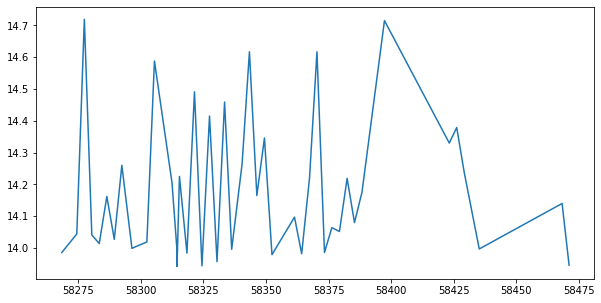

In [53]:
plt.figure(figsize=(10,5))
plt.plot(np.array(obj_mjd), np.array(obj_mag))